# Multi-group Agreement (Adult)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Adult
dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle
import time

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Adult Dataset
The Adult Dataset is a benchmark derived from 1994 US Census data. The task is to predict whether an individual's income
exceeds $50,000 (binary classification). Sensitive attributes are *Race* and *Sex*.

- *Race:* $\{\text{White}, \text{Asian-Pac-Islander}, \text{Amer-Indian-Eskimo}, \text{Other}, \text{Black} \}$
- *Sex:* $\{\text{Male}, \text{Female}\}$

The standard in the literature has been to simplify the groups for *Race* to $\text{White}$ and $\text{NotWhite}$.

## Preprocess and Clean Adult
The Adult dataset is a binary classification task with *categorical* and *numerical* features. We binarize the categorical
features with `OneHotEncoder` and normalize the numerical features with `MinMaxScaler`. We also drop all the rows with missing
features, leaving us with $n = 45,222$ examples total.

In [2]:
# Adult Dataset
adult_names = ["age", "workclass", "fnlwgt", "education", "education-num",
                "marital-status", "occupation", "relationship", "race", "sex",
                "capital-gain", "capital-loss", "hours-per-week", "native-country", 
                "income"]
adult_data = pd.read_csv("./datasets/adult/adult.data", header=None, names=adult_names, na_values=' ?')
adult_data = adult_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
adult_test = pd.read_csv("./datasets/adult/adult.test", header=None, names=adult_names, na_values=' ?')
adult_test = adult_test.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
dfs = [adult_data, adult_test]
adult_df = pd.concat(dfs)
adult_df = adult_df.dropna()
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x) # strip whitespace
print("Adult Shape: {}".format(adult_df.shape))

# last column in adult has some textual discrepancy
adult_df = adult_df.replace(">50K.", ">50K")
adult_df = adult_df.replace("<=50K.", "<=50K")

# Split into X and y
X, y = adult_df.drop("income", axis=1), adult_df["income"]

# Select categorical and numerical features
cat_idx = X.select_dtypes(include=["object", "bool"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variable so we have classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples >=50k (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples <50k (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

Adult Shape: (45222, 15)
% examples >=50k (y=1): 24.78439697492371
% examples <50k (y=0): 75.21560302507629


In [3]:
def adult_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 'White') & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == race_val) & (df['sex'] == sex_val))

group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["White", "NotWhite"]
sex_gps = ["Male", "Female"]

# Traditional disjoint groups
for race in race_gps_coarse:
    for sex in sex_gps:
        indices = adult_gp_indices(X, race, sex)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['race'] == 'White')
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['race'] != 'White')
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['sex'] == 'Male')
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['sex'] == 'Female')
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [4]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (45222, 104)


In [5]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			36177	9045
1 (W,M)			21603	5417
2 (W,F)			9520	2363
3 (nW,M)			2815	692
4 (nW,F)			2239	573
5 (W)			31123	7780
6 (nW)			5054	1265
7 (M)			24418	6109
8 (F)			11759	2936


In [6]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.24378109452736318
P(Y=1 | group 1) = 0.31733431788812994
P(Y=1 | group 2) = 0.12018620397799408
P(Y=1 | group 3) = 0.22687861271676302
P(Y=1 | group 4) = 0.07853403141361257
P(Y=1 | group 5) = 0.25745501285347044
P(Y=1 | group 6) = 0.15968379446640316
P(Y=1 | group 7) = 0.307087903093796
P(Y=1 | group 8) = 0.11205722070844687


## Utilities for Training/Evaluation

In [7]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names):
    # Get test errors for each group
    test_err = {}
    std_errs = {}
    print("Group-conditional ERM Test Errors")
    for g in range(num_groups):
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        std_errs[g] = std_err(test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, test_err[g], std_errs[g], num_group_test[g], group_names[g]))

    print()

    erm_test_err = {}
    erm_std_errs = {}
    print("Overall ERM Test Errors")
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
        erm_std_errs[g] = std_err(erm_test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, erm_test_err[g], erm_std_errs[g], num_group_test[g], group_names[g]))

    return test_err, std_errs, erm_test_err, erm_std_errs
    
def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [41]:
XTICKS = ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)')
def plot_adult_agreements(ax, group_pairs_agreements, group_pairs, group_names, model_class, bar_width=0.2, bar_groups=4, xticks=XTICKS, legend=True):
       # Plot "agreement" for each pair of intersecting groups
       index = np.arange(bar_groups)
       num_group_pairs = len(group_pairs_agreements)

       for i in range(0, num_group_pairs, 3):
              ax.bar(i/(bar_groups - 1) - bar_width, group_pairs_agreements[i], bar_width,
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i][0], group_names[group_pairs[i][0]],
                                                        group_pairs[i][1], group_names[group_pairs[i][1]]))
              ax.bar(i/(bar_groups - 1), group_pairs_agreements[i+1], bar_width,
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i+1][0], group_names[group_pairs[i+1][0]],
                                                        group_pairs[i+1][1], group_names[group_pairs[i+1][1]]))
              ax.bar(i/(bar_groups - 1) + bar_width, group_pairs_agreements[i+2], bar_width,
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i+2][0], group_names[group_pairs[i+2][0]],
                                                        group_pairs[i+2][1], group_names[group_pairs[i+2][1]]))

       ax.set_xlabel('Intersecting Group')
       ax.set_ylabel('Agreement')
       ax.set_title('Group Agreements ({})'.format(model_class))
       ax.set_xticks(index, xticks)
       if legend:
              ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                     fancybox=True, shadow=True, ncol=3)

def plot_adult_errors(ax, test_err, std_errs, erm_test_err, erm_std_errs, model_class, num_groups=num_groups, bar_width=0.2):
       # Error rate plots
       index = np.arange(num_groups)

       for g in range(num_groups):
              if g == 0:
                     ax.bar(g - 0.5 * bar_width, test_err[g], bar_width, yerr=std_errs[g], capsize=3, label="Group-ERM", color="blue")
                     ax.bar(g + 0.5 * bar_width, erm_test_err[g], bar_width, yerr=erm_std_errs[g], capsize=3, label="ERM", color="orange")
              else:
                     ax.bar(g - 0.5 * bar_width, test_err[g], bar_width, yerr=std_errs[g], capsize=3, color="blue")
                     ax.bar(g + 0.5 * bar_width, erm_test_err[g], bar_width, yerr=erm_std_errs[g], capsize=3, color="orange")
              ax.set_ylabel('Group-conditional Error Rate')
              ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM ({})'.format(model_class))

       xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
       ax.set_xticks(index, xticks)
       ax.set_ylim([0, 0.5])
       ax.legend()

In [42]:
# Construct pairs of groups for "agreement" comparison
erm_group_pairs = list()
group_pairs = list()
group_pairs_cond = list()

# append G0 (ALL) paired with all other groups
for i in range(1, num_groups):
    erm_group_pairs.append((0, i))

# append pairs intersecting at G1 (W,M)
group_pairs.append((1,5))
group_pairs_cond.append(1)
group_pairs.append((5,7))
group_pairs_cond.append(1)
group_pairs.append((1,7))
group_pairs_cond.append(1)

# append pairs intersecting at G2 (W,F)
group_pairs.append((2,5))
group_pairs_cond.append(2)
group_pairs.append((5,8))
group_pairs_cond.append(2)
group_pairs.append((2,8))
group_pairs_cond.append(2)

# append pairs intersecting at G3 (nW,M)
group_pairs.append((3,6))
group_pairs_cond.append(3)
group_pairs.append((6,7))
group_pairs_cond.append(3)
group_pairs.append((3,7))
group_pairs_cond.append(3)

# append pairs intersecting at G4 (nW,F)
group_pairs.append((4,6))
group_pairs_cond.append(4)
group_pairs.append((6,8))
group_pairs_cond.append(4)
group_pairs.append((4,8))
group_pairs_cond.append(4)

# Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [44]:
# Train LogisticRegression models, one per group
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

lr_test_err, lr_std_err, lr_erm_test_err, lr_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

Group-conditional ERM Test Errors
group 0 (ALL): 0.1490326147042565 (+/-0.005295510462434083; n=9045)
group 1 (W,M): 0.19198818534244047 (+/-0.0075680098284835315; n=5417)
group 2 (W,F): 0.07829030892932713 (+/-0.00781509420174876; n=2363)
group 3 (nW,M): 0.14017341040462428 (+/-0.01866380576739398; n=692)
group 4 (nW,F): 0.059336823734729496 (+/-0.013957797908572664; n=573)
group 5 (W): 0.15694087403598972 (+/-0.005832063577890563; n=7780)
group 6 (nW): 0.10118577075098814 (+/-0.01199124915107631; n=1265)
group 7 (M): 0.18677361270256998 (+/-0.007051693473778184; n=6109)
group 8 (F): 0.07356948228882834 (+/-0.006813844975828256; n=2936)

Overall ERM Test Errors
group 0 (ALL): 0.1490326147042565 (+/-0.005295510462434083; n=9045)
group 1 (W,M): 0.19254199741554365 (+/-0.0075763196231075644; n=5417)
group 2 (W,F): 0.07448159119763013 (+/-0.007638360312327433; n=2363)
group 3 (nW,M): 0.1416184971098266 (+/-0.018743993133075364; n=692)
group 4 (nW,F): 0.05410122164048865 (+/-0.013364833574

(W,M, W) agreement on G1 (W,M):	0.9909544028059811
(W, M) agreement on G1 (W,M):	0.9900313826841425
(W,M, M) agreement on G1 (W,M):	0.9942772752446003
(W,F, W) agreement on G2 (W,F):	0.9877274650867541
(W, F) agreement on G2 (W,F):	0.9898434193821414
(W,F, F) agreement on G2 (W,F):	0.9953449005501481
(nW,M, nW) agreement on G3 (nW,M):	0.9725433526011561
(nW, M) agreement on G3 (nW,M):	0.9710982658959537
(nW,M, M) agreement on G3 (nW,M):	0.9696531791907514
(nW,F, nW) agreement on G4 (nW,F):	0.9720767888307156
(nW, F) agreement on G4 (nW,F):	0.9825479930191972
(nW,F, F) agreement on G4 (nW,F):	0.9825479930191972


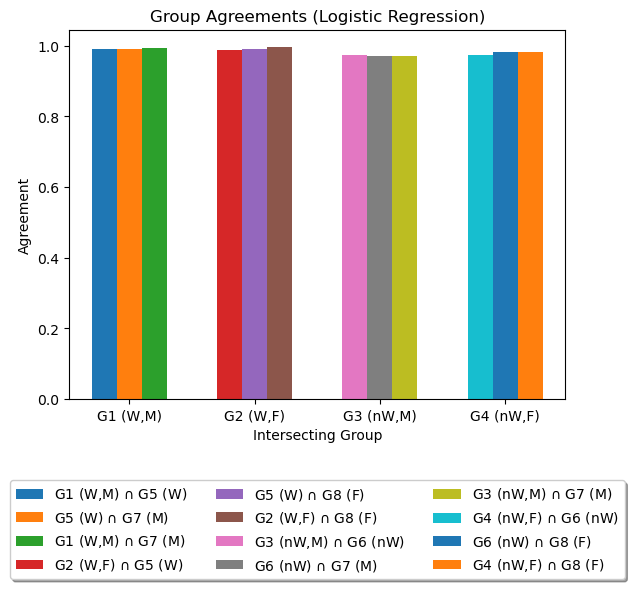

In [45]:
# Get group-conditional agreements
lr_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    lr_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_adult_agreements(ax, lr_group_pairs_agreements, group_pairs, group_names, model_class="Logistic Regression")

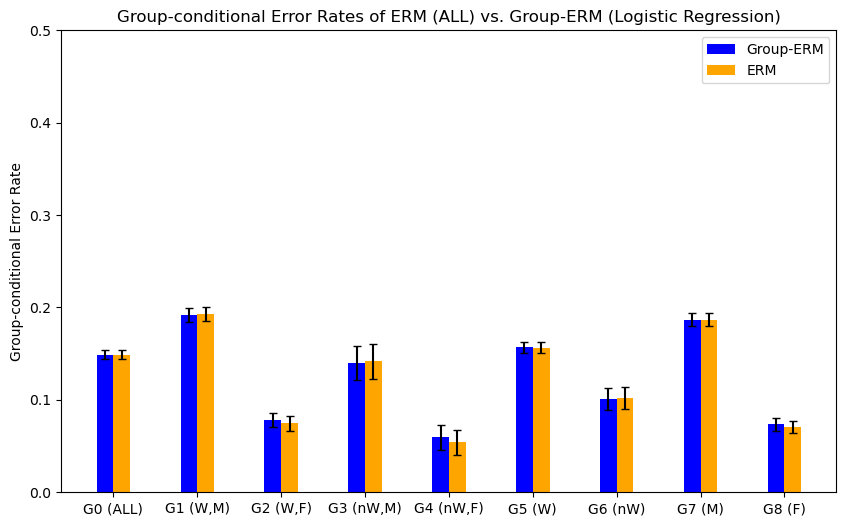

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_adult_errors(ax, lr_test_err, lr_std_err, lr_erm_test_err, lr_erm_std_err, model_class="Logistic Regression")

# Decision Trees

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Get test errors for each group
dt_test_err, dt_std_err, dt_erm_test_err, dt_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

Group-conditional ERM Test Errors
group 0 (ALL): 0.14228855721393036 (+/-0.005194769740701443; n=9045)
group 1 (W,M): 0.18737308473324718 (+/-0.007497816108126731; n=5417)
group 2 (W,F): 0.07151925518408803 (+/-0.007496888976549171; n=2363)
group 3 (nW,M): 0.14017341040462428 (+/-0.01866380576739398; n=692)
group 4 (nW,F): 0.06457242582897033 (+/-0.014519990150373878; n=573)
group 5 (W): 0.1582262210796915 (+/-0.005851431482683345; n=7780)
group 6 (nW): 0.10434782608695652 (+/-0.012155732379760269; n=1265)
group 7 (M): 0.18415452610901947 (+/-0.007013343142461465; n=6109)
group 8 (F): 0.07050408719346049 (+/-0.00668140598132206; n=2936)

Overall ERM Test Errors
group 0 (ALL): 0.14228855721393036 (+/-0.005194769740701443; n=9045)
group 1 (W,M): 0.18478862839209895 (+/-0.007457758496379062; n=5417)
group 2 (W,F): 0.0702496826068557 (+/-0.0074351286559085576; n=2363)
group 3 (nW,M): 0.12572254335260116 (+/-0.017823507359173936; n=692)
group 4 (nW,F): 0.05759162303664921 (+/-0.013763754407

(W,M, W) agreement on G1 (W,M):	0.9553258261030091
(W, M) agreement on G1 (W,M):	0.9844932619531106
(W,M, M) agreement on G1 (W,M):	0.9638176112239247
(W,F, W) agreement on G2 (W,F):	0.9724925941599661
(W, F) agreement on G2 (W,F):	0.9712230215827338
(W,F, F) agreement on G2 (W,F):	0.9970376639864579
(nW,M, nW) agreement on G3 (nW,M):	0.976878612716763
(nW, M) agreement on G3 (nW,M):	0.9812138728323699
(nW,M, M) agreement on G3 (nW,M):	0.9725433526011561
(nW,F, nW) agreement on G4 (nW,F):	0.9685863874345549
(nW, F) agreement on G4 (nW,F):	0.9790575916230366
(nW,F, F) agreement on G4 (nW,F):	0.9650959860383944


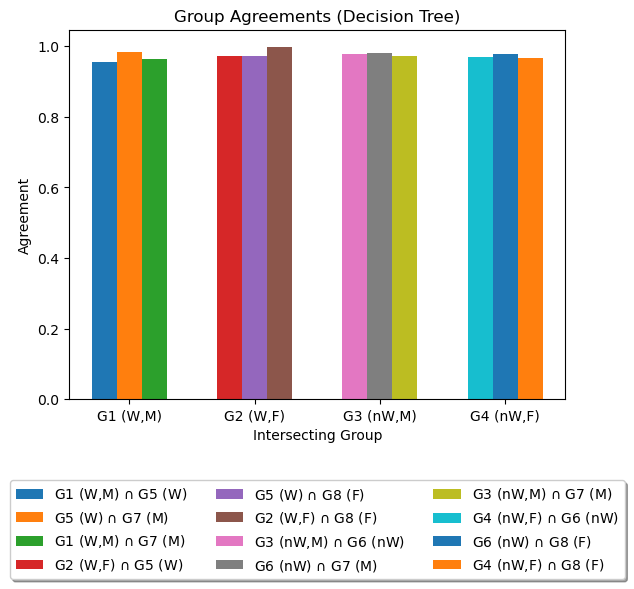

In [49]:
# Get group-conditional agreements
dt_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    dt_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_adult_agreements(ax, dt_group_pairs_agreements, group_pairs, group_names, model_class="Decision Tree")

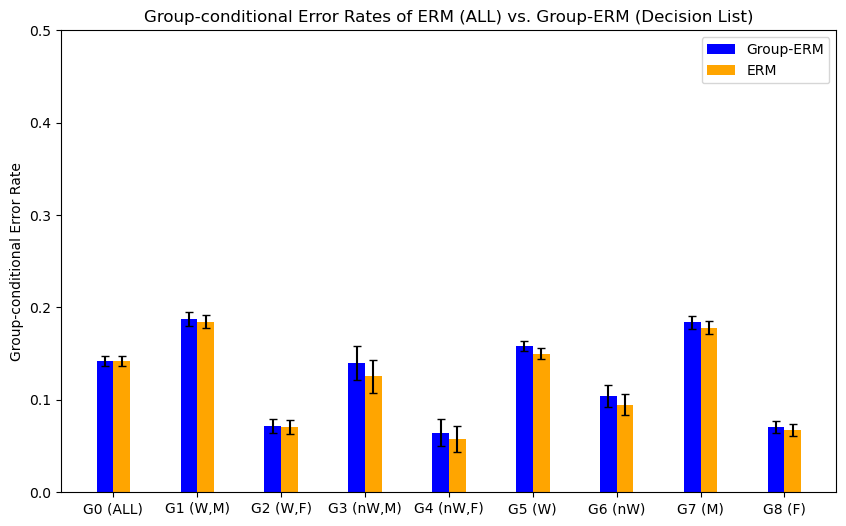

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_adult_errors(ax, dt_test_err, dt_std_err, dt_erm_test_err, dt_erm_std_err, model_class="Decision List")

# Random Forests

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        rf_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err, rf_std_err, rf_erm_test_err, rf_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

Group-conditional ERM Test Errors
group 0 (ALL): 0.13698175787728026 (+/-0.005112720690089159; n=9045)
group 1 (W,M): 0.17998892375853795 (+/-0.0073819029191706555; n=5417)
group 2 (W,F): 0.06940330088870081 (+/-0.007393566000884819; n=2363)
group 3 (nW,M): 0.1329479768786127 (+/-0.018252627677050836; n=692)
group 4 (nW,F): 0.06108202443280977 (+/-0.014148429167305701; n=573)
group 5 (W): 0.1456298200514139 (+/-0.005655531122578966; n=7780)
group 6 (nW): 0.09723320158102766 (+/-0.011780529665332544; n=1265)
group 7 (M): 0.17335079391062366 (+/-0.006849414979831881; n=6109)
group 8 (F): 0.06641689373297002 (+/-0.0064990928920507845; n=2936)

Overall ERM Test Errors
group 0 (ALL): 0.13698175787728026 (+/-0.005112720690089159; n=9045)
group 1 (W,M): 0.17721986339302198 (+/-0.007337256100602848; n=5417)
group 2 (W,F): 0.06813372831146847 (+/-0.007330625119647967; n=2363)
group 3 (nW,M): 0.12427745664739884 (+/-0.017735416578253768; n=692)
group 4 (nW,F): 0.055846422338568937 (+/-0.01356615

(W,M, W) agreement on G1 (W,M):	0.9822780136606978
(W, M) agreement on G1 (W,M):	0.9841240539043751
(W,M, M) agreement on G1 (W,M):	0.9837548458556397
(W,F, W) agreement on G2 (W,F):	0.9881506559458316
(W, F) agreement on G2 (W,F):	0.988573846804909
(W,F, F) agreement on G2 (W,F):	0.9944985188319933
(nW,M, nW) agreement on G3 (nW,M):	0.9826589595375722
(nW, M) agreement on G3 (nW,M):	0.9710982658959537
(nW,M, M) agreement on G3 (nW,M):	0.9624277456647399
(nW,F, nW) agreement on G4 (nW,F):	0.9860383944153578
(nW, F) agreement on G4 (nW,F):	0.9842931937172775
(nW,F, F) agreement on G4 (nW,F):	0.9703315881326352


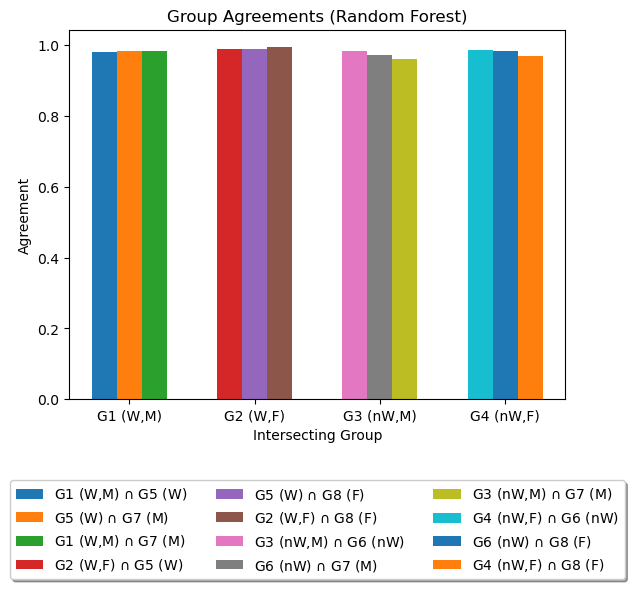

In [53]:
# Get group-conditional agreements
rf_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    rf_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_adult_agreements(ax, rf_group_pairs_agreements, group_pairs, group_names, model_class="Random Forest")

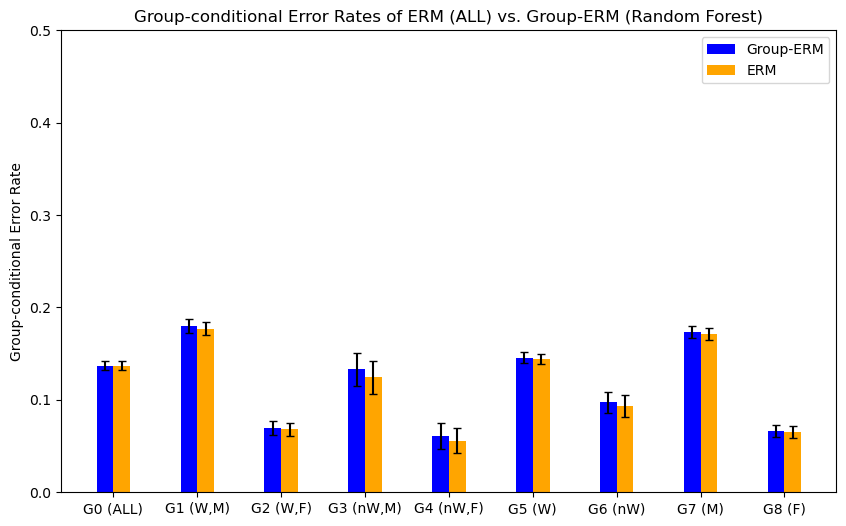

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_adult_errors(ax, rf_test_err, rf_std_err, rf_erm_test_err, rf_erm_std_err, model_class="Random Forest")

# Gradient-Boosted Trees

In [55]:
from sklearn.ensemble import GradientBoostingClassifier

In [56]:
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

gb_test_err, gb_std_err, gb_erm_test_err, gb_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

Group-conditional ERM Test Errors
group 0 (ALL): 0.12924267551133223 (+/-0.004988411254187812; n=9045)
group 1 (W,M): 0.17057411851578363 (+/-0.007227380828345427; n=5417)
group 2 (W,F): 0.06601777401608125 (+/-0.007224085562431033; n=2363)
group 3 (nW,M): 0.12283236994219653 (+/-0.017646544048870536; n=692)
group 4 (nW,F): 0.055846422338568937 (+/-0.013566152245142996; n=573)
group 5 (W): 0.13791773778920308 (+/-0.005528529311456888; n=7780)
group 6 (nW): 0.09723320158102766 (+/-0.011780529665332544; n=1265)
group 7 (M): 0.16532984121787528 (+/-0.006721450474964076; n=6109)
group 8 (F): 0.0653950953678474 (+/-0.006452434265404928; n=2936)

Overall ERM Test Errors
group 0 (ALL): 0.12924267551133223 (+/-0.004988411254187812; n=9045)
group 1 (W,M): 0.16706664205279675 (+/-0.007167795059355567; n=5417)
group 2 (W,F): 0.06771053745239103 (+/-0.007309482914285193; n=2363)
group 3 (nW,M): 0.11127167630057803 (+/-0.016905918718834945; n=692)
group 4 (nW,F): 0.04712041884816754 (+/-0.012518758

(W,M, W) agreement on G1 (W,M):	0.985600886099317
(W, M) agreement on G1 (W,M):	0.9843086579287429
(W,M, M) agreement on G1 (W,M):	0.9902159867085103
(W,F, W) agreement on G2 (W,F):	0.9877274650867541
(W, F) agreement on G2 (W,F):	0.9873042742276766
(W,F, F) agreement on G2 (W,F):	0.9911129919593736
(nW,M, nW) agreement on G3 (nW,M):	0.9609826589595376
(nW, M) agreement on G3 (nW,M):	0.9436416184971098
(nW,M, M) agreement on G3 (nW,M):	0.9566473988439307
(nW,F, nW) agreement on G4 (nW,F):	0.9842931937172775
(nW, F) agreement on G4 (nW,F):	0.9825479930191972
(nW,F, F) agreement on G4 (nW,F):	0.987783595113438


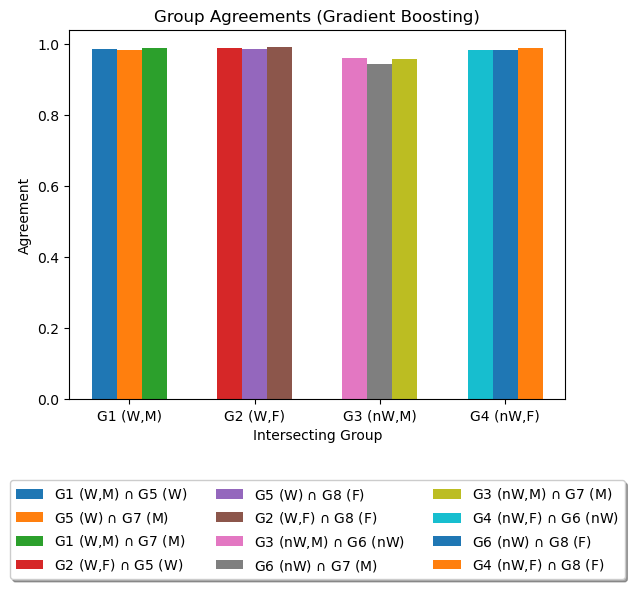

In [57]:
# Get group-conditional agreements
gb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    gb_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_adult_agreements(ax, gb_group_pairs_agreements, group_pairs, group_names, model_class="Gradient Boosting")

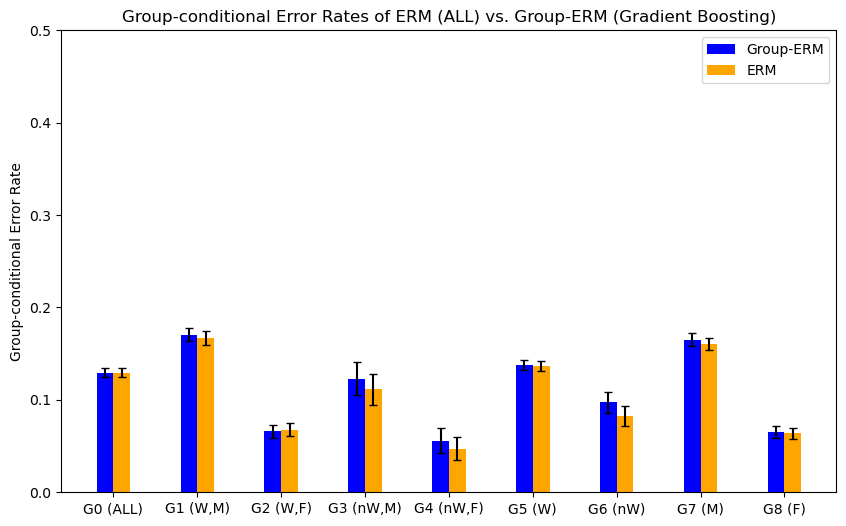

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_adult_errors(ax, gb_test_err, gb_std_err, gb_erm_test_err, gb_erm_std_err, model_class="Gradient Boosting")

# XGBoost

In [59]:
from xgboost import XGBClassifier

In [60]:
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

xgb_test_err, xgb_std_err, xgb_erm_test_err, xgb_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

Group-conditional ERM Test Errors
group 0 (ALL): 0.13012714206744058 (+/-0.005002908362872241; n=9045)
group 1 (W,M): 0.1679896621746354 (+/-0.007183584747175932; n=5417)
group 2 (W,F): 0.06771053745239103 (+/-0.007309482914285193; n=2363)
group 3 (nW,M): 0.12427745664739884 (+/-0.017735416578253768; n=692)
group 4 (nW,F): 0.06108202443280977 (+/-0.014148429167305701; n=573)
group 5 (W): 0.137146529562982 (+/-0.005515515833348758; n=7780)
group 6 (nW): 0.091699604743083 (+/-0.011475410193262332; n=1265)
group 7 (M): 0.16221967588803404 (+/-0.00667032167440799; n=6109)
group 8 (F): 0.06471389645776567 (+/-0.006421078626222198; n=2936)

Overall ERM Test Errors
group 0 (ALL): 0.13012714206744058 (+/-0.005002908362872241; n=9045)
group 1 (W,M): 0.1685434742477386 (+/-0.0071930209323602615; n=5417)
group 2 (W,F): 0.06178586542530681 (+/-0.007004525002537611; n=2363)
group 3 (nW,M): 0.12861271676300579 (+/-0.01799738949036107; n=692)
group 4 (nW,F): 0.0506108202443281 (+/-0.01295035023056620

(W,M, W) agreement on G1 (W,M):	0.969724940003692
(W, M) agreement on G1 (W,M):	0.9739708325641498
(W,M, M) agreement on G1 (W,M):	0.9857854901236847
(W,F, W) agreement on G2 (W,F):	0.9792636479052053
(W, F) agreement on G2 (W,F):	0.9830723656369023
(W,F, F) agreement on G2 (W,F):	0.9902666102412188
(nW,M, nW) agreement on G3 (nW,M):	0.9393063583815029
(nW, M) agreement on G3 (nW,M):	0.953757225433526
(nW,M, M) agreement on G3 (nW,M):	0.9421965317919075
(nW,F, nW) agreement on G4 (nW,F):	0.9912739965095986
(nW, F) agreement on G4 (nW,F):	0.9808027923211169
(nW,F, F) agreement on G4 (nW,F):	0.9755671902268761


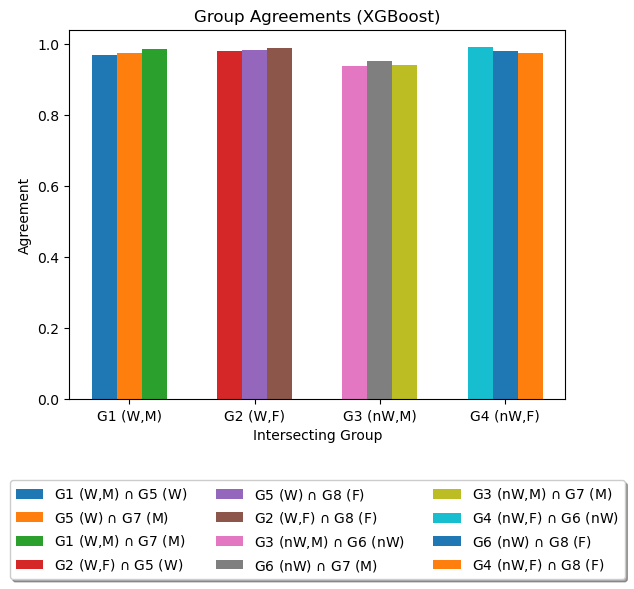

In [61]:
# Get group-conditional agreements
xgb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    xgb_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_adult_agreements(ax, xgb_group_pairs_agreements, group_pairs, group_names, model_class="XGBoost")

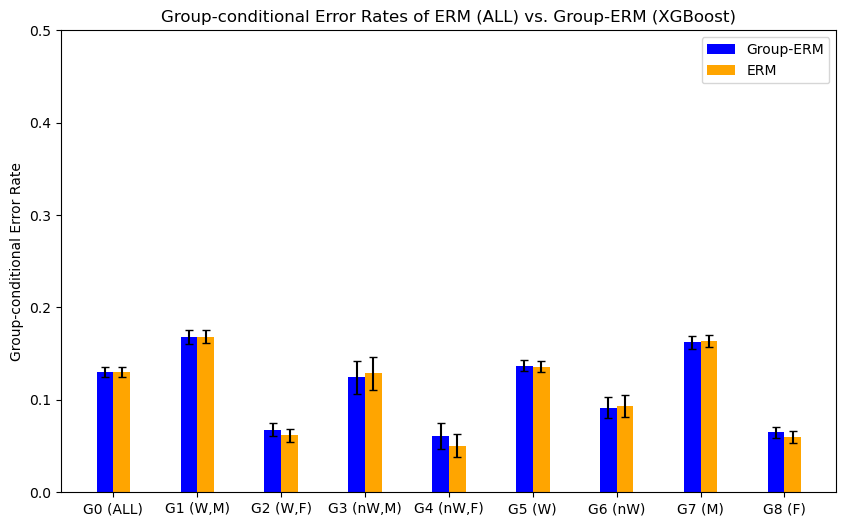

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_adult_errors(ax, xgb_test_err, xgb_std_err, xgb_erm_test_err, xgb_erm_std_err, model_class="XGBoost")

# AdaBoost

In [63]:
from sklearn.ensemble import AdaBoostClassifier

In [64]:
LOAD_DATA = True
SAVE_DATA_PATH = 'adult_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

ada_test_err, ada_std_err, ada_erm_test_err, ada_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

Group-conditional ERM Test Errors
group 0 (ALL): 0.14118297401879493 (+/-0.00517788258598975; n=9045)
group 1 (W,M): 0.1803581318072734 (+/-0.007387806489926905; n=5417)
group 2 (W,F): 0.07194244604316546 (+/-0.0075173226667870595; n=2363)
group 3 (nW,M): 0.13005780346820808 (+/-0.01808320295121033; n=692)
group 4 (nW,F): 0.055846422338568937 (+/-0.013566152245142996; n=573)
group 5 (W): 0.1461439588688946 (+/-0.00566380067499941; n=7780)
group 6 (nW): 0.10513833992094862 (+/-0.012196304073073557; n=1265)
group 7 (M): 0.17531510885578655 (+/-0.006879923783935992; n=6109)
group 8 (F): 0.0681198910081744 (+/-0.00657588130132432; n=2936)

Overall ERM Test Errors
group 0 (ALL): 0.14118297401879493 (+/-0.00517788258598975; n=9045)
group 1 (W,M): 0.1833117961971571 (+/-0.007434622605162926; n=5417)
group 2 (W,F): 0.0664409648751587 (+/-0.007245560641891943; n=2363)
group 3 (nW,M): 0.13439306358381503 (+/-0.01833625929006566; n=692)
group 4 (nW,F): 0.059336823734729496 (+/-0.01395779790857266

(W,M, W) agreement on G1 (W,M):	0.9660328595163374
(W, M) agreement on G1 (W,M):	0.976001476832195
(W,M, M) agreement on G1 (W,M):	0.9771091009784013
(W,F, W) agreement on G2 (W,F):	0.9754549301735083
(W, F) agreement on G2 (W,F):	0.9767245027507406
(W,F, F) agreement on G2 (W,F):	0.9911129919593736
(nW,M, nW) agreement on G3 (nW,M):	0.9508670520231214
(nW, M) agreement on G3 (nW,M):	0.9624277456647399
(nW,M, M) agreement on G3 (nW,M):	0.9335260115606936
(nW,F, nW) agreement on G4 (nW,F):	0.9912739965095986
(nW, F) agreement on G4 (nW,F):	0.9825479930191972
(nW,F, F) agreement on G4 (nW,F):	0.987783595113438


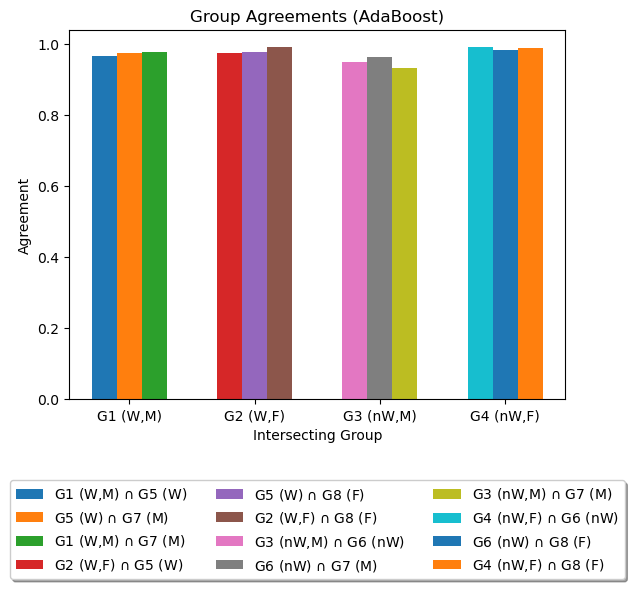

In [65]:
# Get group-conditional agreements
ada_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    ada_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_adult_agreements(ax, ada_group_pairs_agreements, group_pairs, group_names, model_class="AdaBoost")

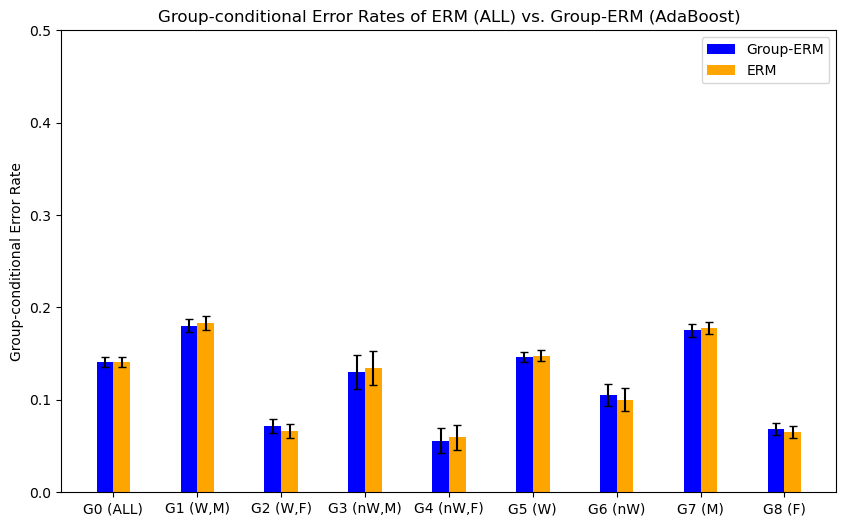

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_adult_errors(ax, ada_test_err, ada_std_err, ada_erm_test_err, ada_erm_std_err, model_class="AdaBoost")

# All Together, Now

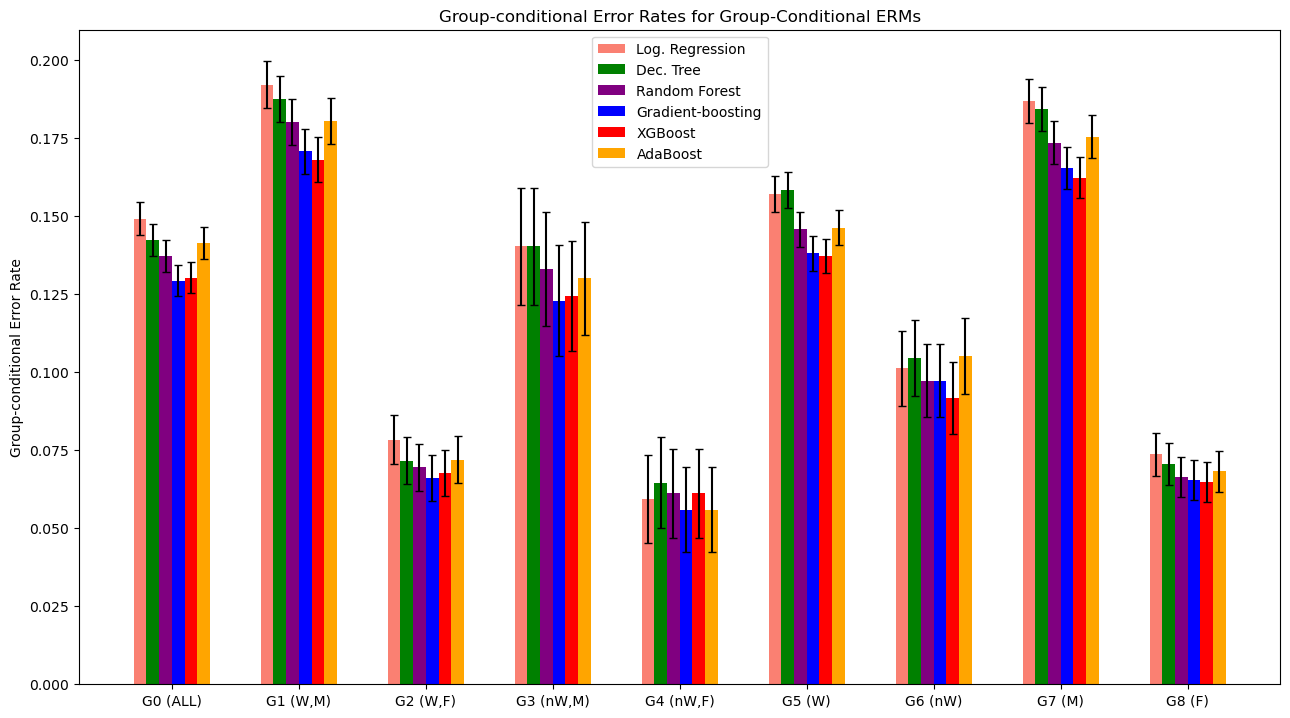

In [67]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2.5 * bar_width, lr_test_err[g], bar_width, yerr=lr_std_err[g], capsize=3, label="Log. Regression", color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_test_err[g], bar_width, yerr=dt_std_err[g], capsize=3, label="Dec. Tree", color="green")
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, yerr=rf_std_err[g], capsize=3, label="Random Forest", color="purple")
        ax.bar(g + 0.5 * bar_width, gb_test_err[g], bar_width, yerr=gb_std_err[g], capsize=3, label="Gradient-boosting", color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_test_err[g], bar_width, yerr=xgb_std_err[g], capsize=3, label="XGBoost", color="red")
        ax.bar(g + 2.5 * bar_width, ada_test_err[g], bar_width, yerr=ada_std_err[g], capsize=3, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2.5 * bar_width, lr_test_err[g], bar_width, yerr=lr_std_err[g], capsize=3, color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_test_err[g], bar_width, yerr=dt_std_err[g], capsize=3, color="green")
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, yerr=rf_std_err[g], capsize=3, color="purple")
        ax.bar(g + 0.5 * bar_width, gb_test_err[g], bar_width, yerr=gb_std_err[g], capsize=3, color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_test_err[g], bar_width, yerr=xgb_std_err[g], capsize=3, color="red")
        ax.bar(g + 2.5 * bar_width, ada_test_err[g], bar_width, yerr=ada_std_err[g], capsize=3, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates for Group-Conditional ERMs')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

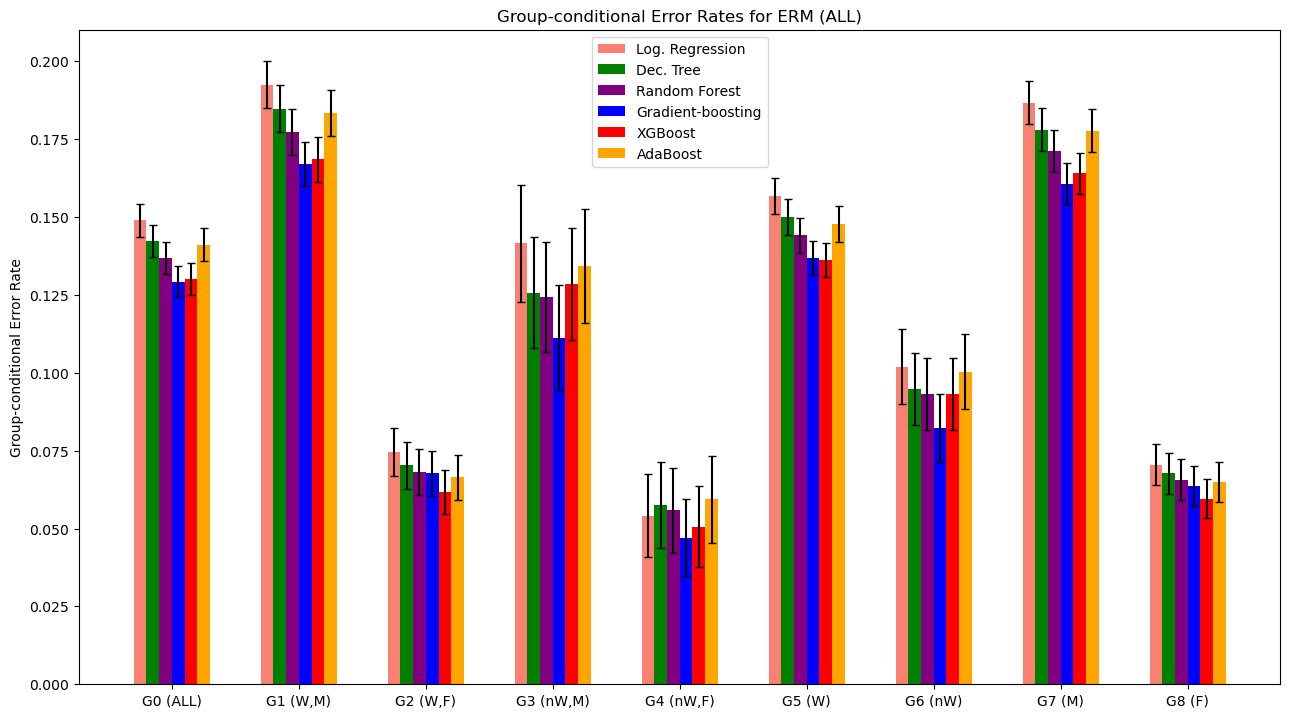

In [68]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2.5 * bar_width, lr_erm_test_err[g], bar_width, yerr=lr_erm_std_err[g], capsize=3, label="Log. Regression", color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_erm_test_err[g], bar_width, yerr=dt_erm_std_err[g], capsize=3, label="Dec. Tree", color="green")
        ax.bar(g - 0.5 * bar_width, rf_erm_test_err[g], bar_width, yerr=rf_erm_std_err[g], capsize=3, label="Random Forest", color="purple")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, yerr=gb_erm_std_err[g], capsize=3, label="Gradient-boosting", color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_erm_test_err[g], bar_width, yerr=xgb_erm_std_err[g], capsize=3, label="XGBoost", color="red")
        ax.bar(g + 2.5 * bar_width, ada_erm_test_err[g], bar_width, yerr=ada_erm_std_err[g], capsize=3, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2.5 * bar_width, lr_erm_test_err[g], bar_width, yerr=lr_erm_std_err[g], capsize=3, color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_erm_test_err[g], bar_width, yerr=dt_erm_std_err[g], capsize=3, color="green")
        ax.bar(g - 0.5 * bar_width, rf_erm_test_err[g], bar_width, yerr=rf_erm_std_err[g], capsize=3, color="purple")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, yerr=gb_erm_std_err[g], capsize=3, color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_erm_test_err[g], bar_width, yerr=xgb_erm_std_err[g], capsize=3, color="red")
        ax.bar(g + 2.5 * bar_width, ada_erm_test_err[g], bar_width, yerr=ada_erm_std_err[g], capsize=3, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates for ERM (ALL)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

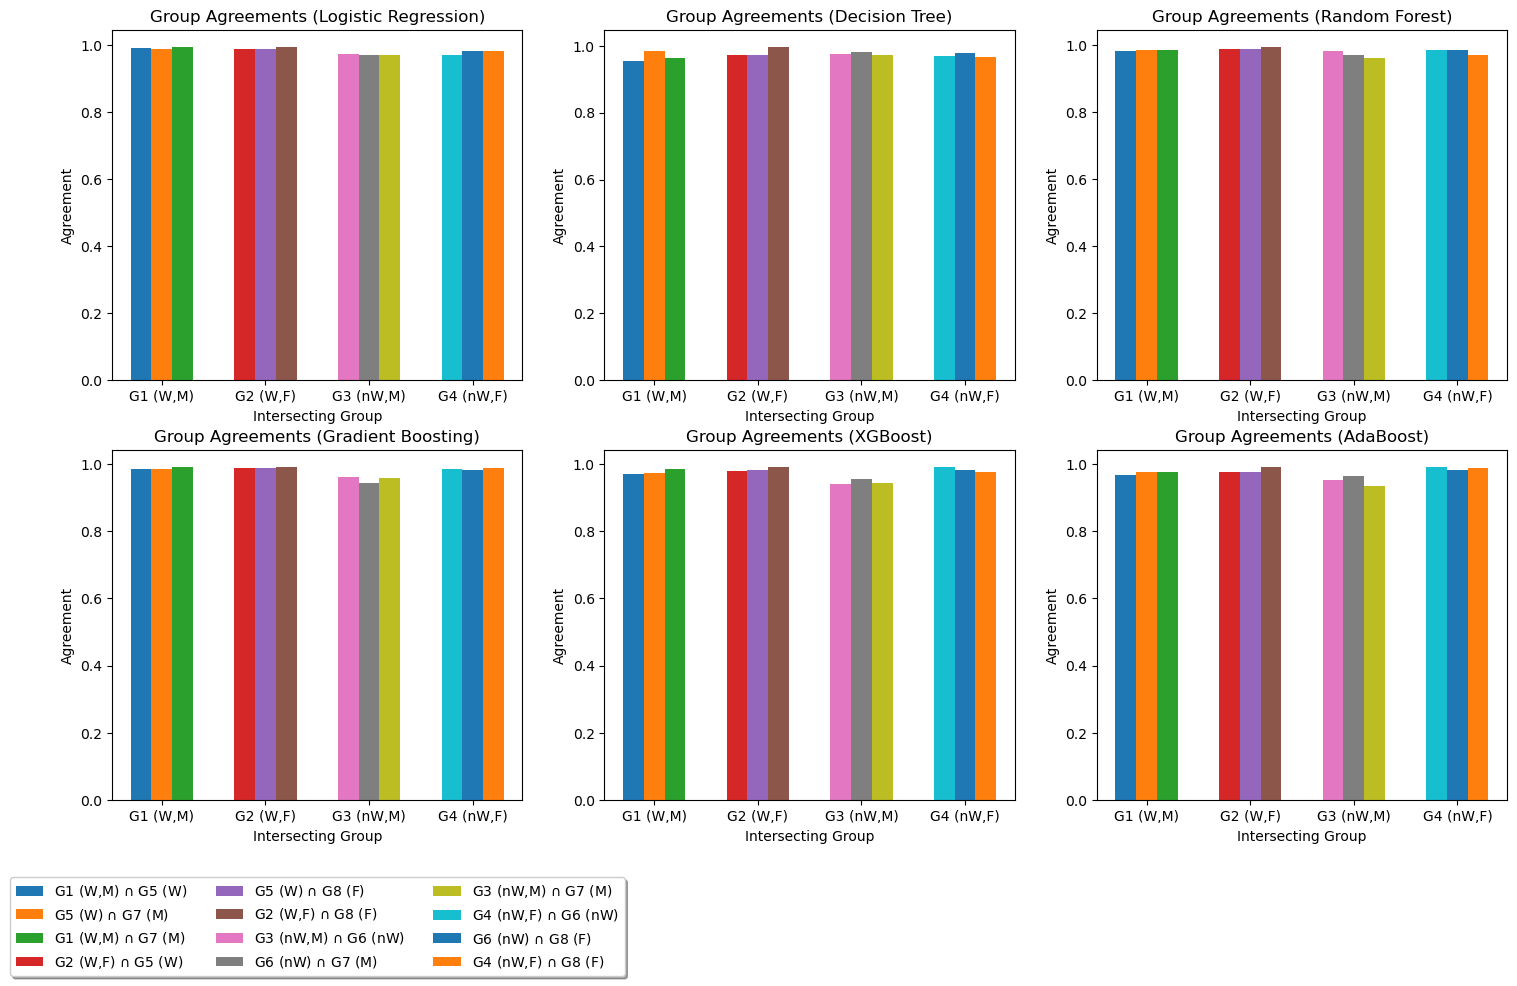

In [69]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18, 10)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

plot_adult_agreements(ax[0][0], lr_group_pairs_agreements, group_pairs, group_names, model_class="Logistic Regression", legend=False)
plot_adult_agreements(ax[0][1], dt_group_pairs_agreements, group_pairs, group_names, model_class="Decision Tree", legend=False)
plot_adult_agreements(ax[0][2], rf_group_pairs_agreements, group_pairs, group_names, model_class="Random Forest", legend=False)
plot_adult_agreements(ax[1][0], gb_group_pairs_agreements, group_pairs, group_names, model_class="Gradient Boosting", legend=False)
plot_adult_agreements(ax[1][1], xgb_group_pairs_agreements, group_pairs, group_names, model_class="XGBoost", legend=False)
plot_adult_agreements(ax[1][2], ada_group_pairs_agreements, group_pairs, group_names, model_class="AdaBoost", legend=False)

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

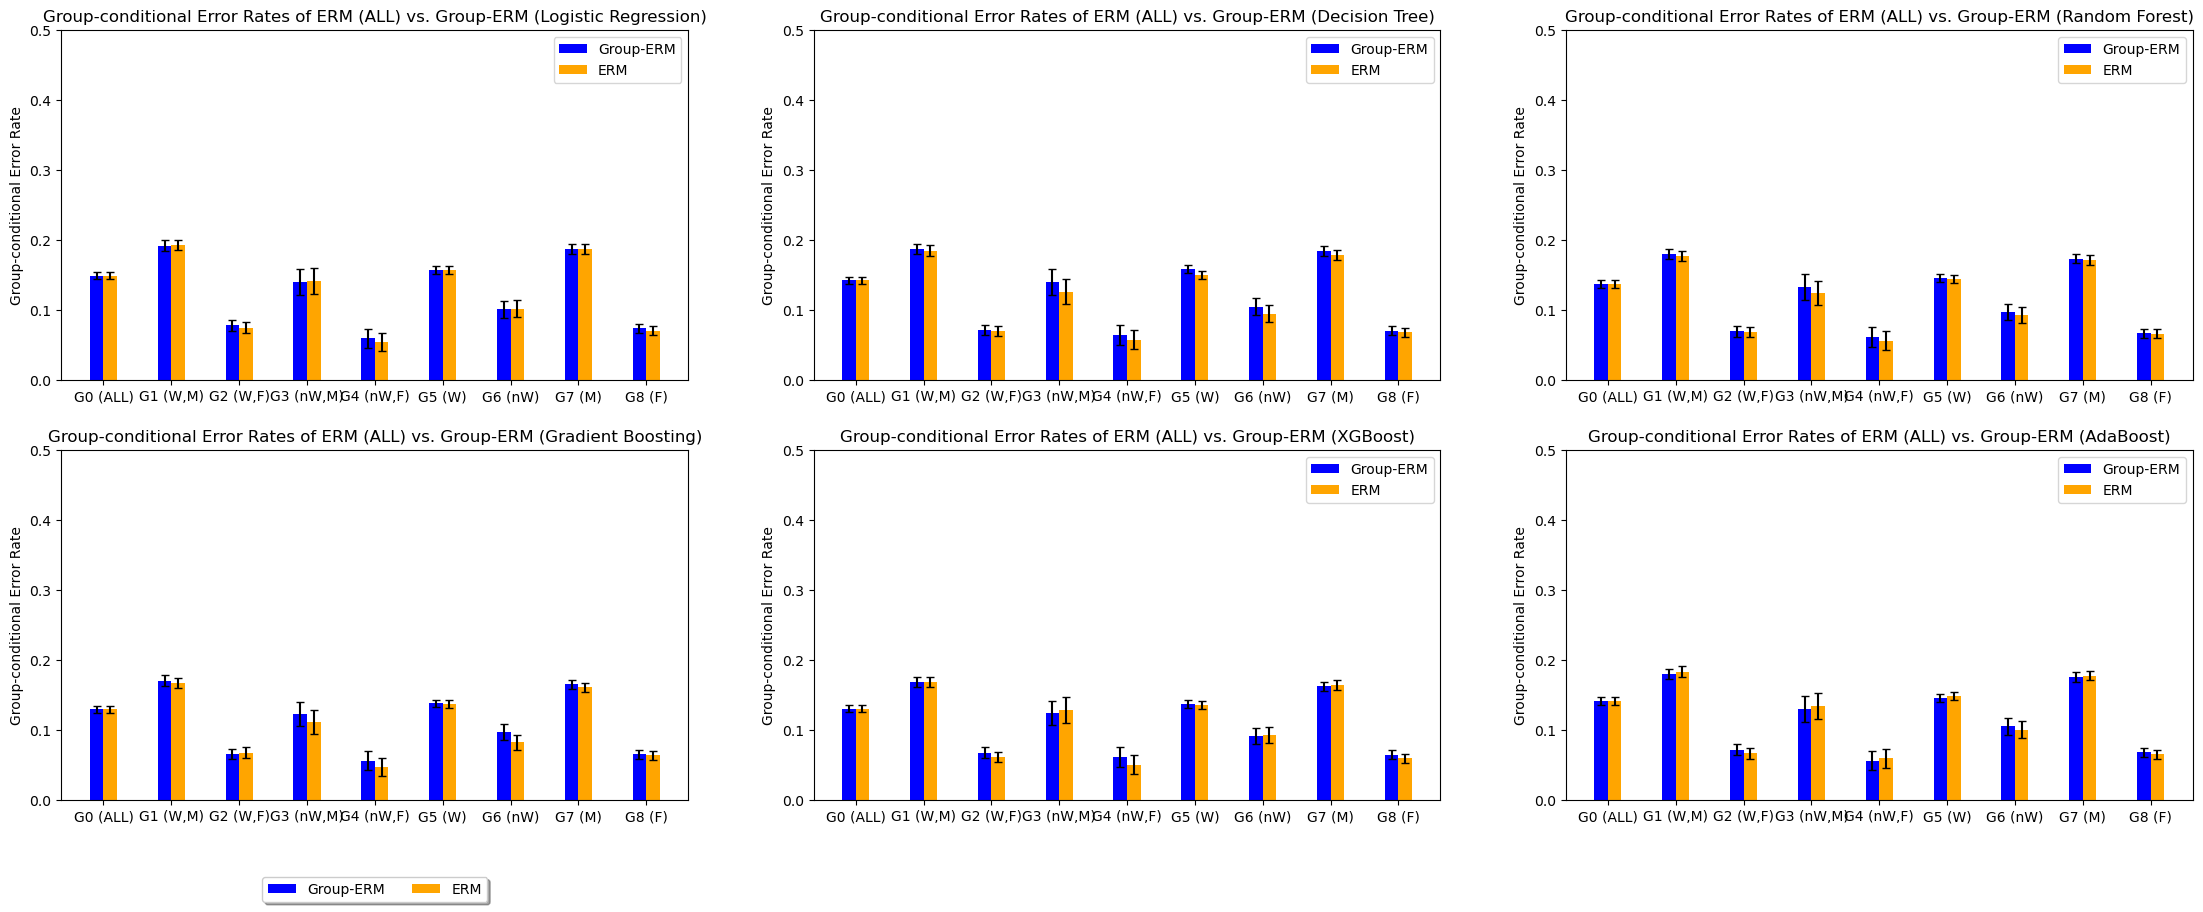

In [72]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(27.5, 10)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

plot_adult_errors(ax[0][0], lr_test_err, lr_std_err, lr_erm_test_err, lr_erm_std_err, model_class="Logistic Regression")
plot_adult_errors(ax[0][1], dt_test_err, dt_std_err, dt_erm_test_err, dt_erm_std_err, model_class="Decision Tree")
plot_adult_errors(ax[0][2], rf_test_err, rf_std_err, rf_erm_test_err, rf_erm_std_err, model_class="Random Forest")
plot_adult_errors(ax[1][0], gb_test_err, gb_std_err, gb_erm_test_err, gb_erm_std_err, model_class="Gradient Boosting")
plot_adult_errors(ax[1][1], xgb_test_err, xgb_std_err, xgb_erm_test_err, xgb_erm_std_err, model_class="XGBoost")
plot_adult_errors(ax[1][2], ada_test_err, ada_std_err, ada_erm_test_err, ada_erm_std_err, model_class="AdaBoost")

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

## Closer look at agreements

In [71]:
cond_interest = [1, 4, 7, 10]
for i, (g1, g2) in enumerate(group_pairs):
    if i in cond_interest:
        intersection = group_pairs_cond[i]
        print("({}, {}) agreement on {} ({}):\t\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "Log. Regression",
                                                          lr_group_pairs_agreements[i]))
        print("({}, {}) agreement on {} ({}):\t\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "Decision Tree",
                                                          dt_group_pairs_agreements[i]))
        print("({}, {}) agreement on {} ({}):\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "Gradient-Boosted Trees",
                                                          gb_group_pairs_agreements[i]))
        print("({}, {}) agreement on {} ({}):\t\t\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "XGBoost",
                                                          xgb_group_pairs_agreements[i]))
        print("({}, {}) agreement on {} ({}):\t\t\t{}".format(group_names[g1], group_names[g2], 
                                                          group_names[intersection], "AdaBoost",
                                                          ada_group_pairs_agreements[i]))
        print()

(W, M) agreement on W,M (Log. Regression):		0.9900313826841425
(W, M) agreement on W,M (Decision Tree):		0.9844932619531106
(W, M) agreement on W,M (Gradient-Boosted Trees):	0.9843086579287429
(W, M) agreement on W,M (XGBoost):			0.9739708325641498
(W, M) agreement on W,M (AdaBoost):			0.976001476832195

(W, F) agreement on W,F (Log. Regression):		0.9898434193821414
(W, F) agreement on W,F (Decision Tree):		0.9712230215827338
(W, F) agreement on W,F (Gradient-Boosted Trees):	0.9873042742276766
(W, F) agreement on W,F (XGBoost):			0.9830723656369023
(W, F) agreement on W,F (AdaBoost):			0.9767245027507406

(nW, M) agreement on nW,M (Log. Regression):		0.9710982658959537
(nW, M) agreement on nW,M (Decision Tree):		0.9812138728323699
(nW, M) agreement on nW,M (Gradient-Boosted Trees):	0.9436416184971098
(nW, M) agreement on nW,M (XGBoost):			0.953757225433526
(nW, M) agreement on nW,M (AdaBoost):			0.9624277456647399

(nW, F) agreement on nW,F (Log. Regression):		0.9825479930191972
(nW, F

One thing to notice is that, while agreement is pretty similar for all groups, the agreeement on `(nW, M)` for Gradient-Boosted Trees
and XGBoost is lower by a noticeable amount.